In [75]:
#
# NCFApp
# New Customers Forecast Application
# Programma creato per il forecast dei clienti
# 

import numpy             as np   # libreria per la gestione dei numeri
import pandas            as pd   # libreria per la gestione del file csv
import seaborn           as sb   # libreria per la costruzione di grafici
import matplotlib.pyplot as plt  # libreria ausiliaria per la costruzione di grafici
import Tkinter           as tk   # libreria per l'interfaccia grafica
import PIL                       # libreria per la gestione delle immagini
from statsmodels.tsa.stattools   import acf, pacf, adfuller
from statsmodels.tsa.seasonal    import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults

# Carica il dataframe dei dati dal file csv
df_sstor = pd.read_csv('NCFAdati.csv',sep=',',index_col=0, parse_dates=True, infer_datetime_format=True)
# Converte la prima colonna 'MESE' da stringa a data
#df_sstor['MESE']=pd.to_datetime(df_sstor['MESE'],format='%Y/%m')


# Funzione che espone l'ultimo consuntivo caricato
def Lastcons():
    df_mesi = df_sstor['MESE']
    return max(df_mesi)

# Funzione che prepara un grafico e lo salva in una figura
def SimplePlot(SeriePandas=None,LabelofSerie=None):
    plt.plot(SeriePandas,label=LabelofSerie)
    plt.legend()
    return plt.figure()


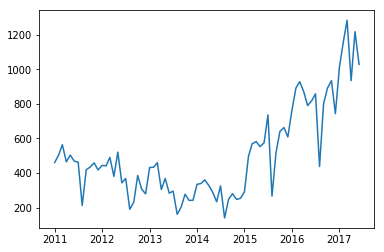

In [76]:
SP = df_sstor['FL_IMP']
a=plt.plot(SP)
plt.show(a)

In [48]:
# Funzione che data una serie ne calcola il forecast
def Forecast(SeriePandas=None):
    #Elimina eventuali spazi vuoti
    SeriePandas = SeriePandas.dropna()
    #Calcola media mobile e deviazione standard su 12 periodi
    rolmean = SeriePandas.rolling(window=12,center=False).mean()
    rolstd  = SeriePandas.rolling(window=12,center=False).std()
    
    
    plt.plot(SP)
    plt.plot(rolmean)
    plt.title('Original series and Rolling Mean')
    plt.show()
    plt.plot(rolstd)
    plt.title('Rolling Standard Deviation')
    plt.show()
    
    
    dftest = adfuller(SeriePandas, autolag='AIC')
    print dftest
    print 'Results of Dickey-Fuller Test:'
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
    
    
    decomposition = seasonal_decompose(SeriePandas.dropna())

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    
    plt.subplot(411)
    plt.plot(SeriePandas, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    plt.show()
    
    dftest = adfuller(residual.dropna(), autolag='AIC')
    print dftest
    print 'Results of Dickey-Fuller Test:'
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
    
    lag_acf = acf(residual.dropna(), nlags=15)
    lag_pacf = pacf(residual.dropna(), nlags=15, method='ols')

    print 'lag ACF :  ',lag_acf
    print 'lag PACF : ',lag_pacf
    
    #Plot ACF: 
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(residual.dropna())),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(residual.dropna())),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
        
    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(residual.dropna())),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(residual.dropna())),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    plt.show()
    
    model = ARIMA(residual.dropna(),order=(1,1,0))
    results_AR = model.fit(disp=-1)  
    plt.plot(residual.dropna())
    plt.plot(results_AR.fittedvalues, color='red')
    plt.title('RSS: %.4f'% sum((results_AR.fittedvalues.dropna()-residual.dropna())**2))
    plt.show()
    
    plt.plot(results_AR.forecast(12))
    plt.show()
    #worklist=[]
    #for i in range(12,len(SeriePandas)):
    #    worklist.insert(i-12,SeriePandas[i]-SeriePandas[i-12])
    #avgtrend = np.mean(worklist)/12
    
    #trendlist=[]
    #for i in range(0,len(SeriePandas)-1):
    #    trendlist.insert(i,i*avgtrend)
        
    #worklist1=[]
    #for i in range(0,len(SeriePandas)-1):
    #    worklist1.insert(i,SeriePandas[i]-trendlist[i])
    #constant = np.mean(worklist1)
    
    #worklist2 = worklist1-constant
    
    #return worklist2,constant


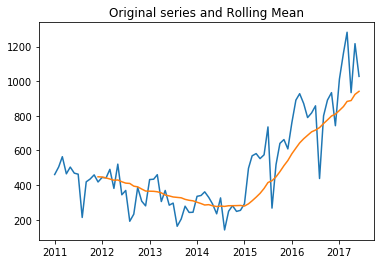

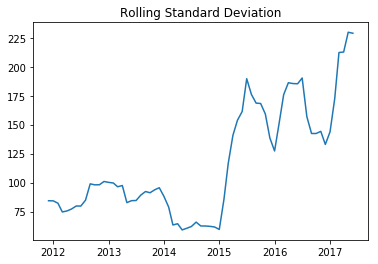

(0.27713736568232361, 0.97627090209061373, 12, 65, {'5%': -2.9071540828402367, '1%': -3.5352168748293127, '10%': -2.5911025443786984}, 787.29046527473281)
Results of Dickey-Fuller Test:
Test Statistic                  0.277137
p-value                         0.976271
#Lags Used                     12.000000
Number of Observations Used    65.000000
Critical Value (5%)            -2.907154
Critical Value (1%)            -3.535217
Critical Value (10%)           -2.591103
dtype: float64


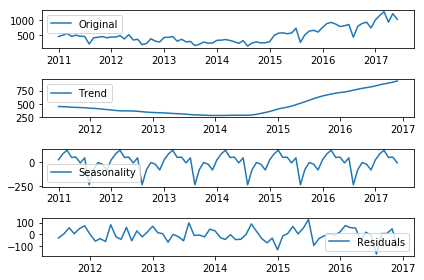

(-6.4602673256956473, 1.449093998320106e-08, 5, 60, {'5%': -2.9110731481481484, '1%': -3.5443688564814813, '10%': -2.5931902777777776}, 585.01976371635624)
Results of Dickey-Fuller Test:
Test Statistic                -6.460267e+00
p-value                        1.449094e-08
#Lags Used                     5.000000e+00
Number of Observations Used    6.000000e+01
Critical Value (5%)           -2.911073e+00
Critical Value (1%)           -3.544369e+00
Critical Value (10%)          -2.593190e+00
dtype: float64
lag ACF :   [ 1.          0.02978173 -0.0434193  -0.0703328  -0.12883766 -0.18629649
 -0.32600933  0.17578216  0.16941396  0.06469612  0.02140541  0.05225555
  0.12706635 -0.29285616 -0.12439842 -0.0195546 ]
lag PACF :  [ 1.          0.0314     -0.04899138 -0.07226949 -0.13536122 -0.24265464
 -0.49381559  0.15306178  0.12879153 -0.00567029 -0.11759278 -0.01542719
  0.2126447  -0.17097543 -0.12294034 -0.09087353]


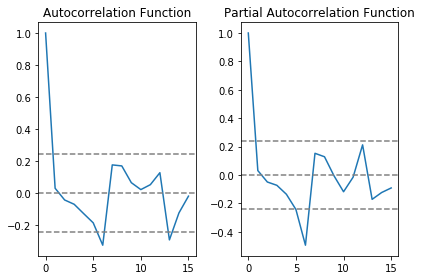

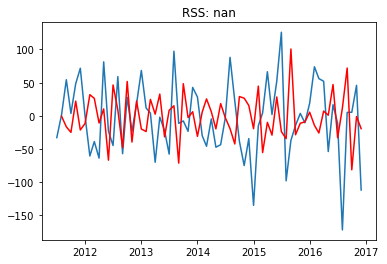

ValueError: could not broadcast input array from shape (12,2) into shape (12)

In [49]:
print Forecast(SP)

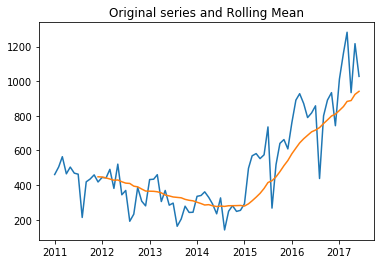

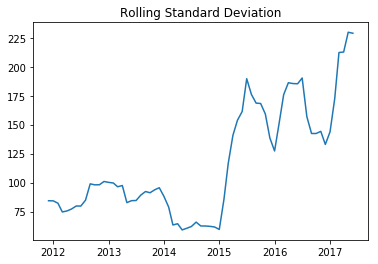

(0.27713736568232361, 0.97627090209061373, 12, 65, {'5%': -2.9071540828402367, '1%': -3.5352168748293127, '10%': -2.5911025443786984}, 787.29046527473281)
Results of Dickey-Fuller Test:
Test Statistic                  0.277137
p-value                         0.976271
#Lags Used                     12.000000
Number of Observations Used    65.000000
Critical Value (5%)            -2.907154
Critical Value (1%)            -3.535217
Critical Value (10%)           -2.591103
dtype: float64


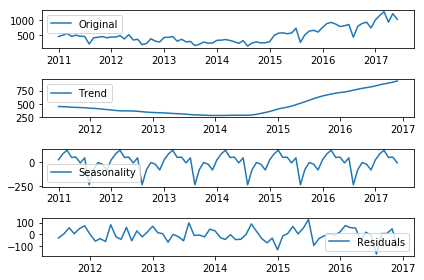

(-6.4602673256956473, 1.449093998320106e-08, 5, 60, {'5%': -2.9110731481481484, '1%': -3.5443688564814813, '10%': -2.5931902777777776}, 585.01976371635624)
Results of Dickey-Fuller Test:
Test Statistic                -6.460267e+00
p-value                        1.449094e-08
#Lags Used                     5.000000e+00
Number of Observations Used    6.000000e+01
Critical Value (5%)           -2.911073e+00
Critical Value (1%)           -3.544369e+00
Critical Value (10%)          -2.593190e+00
dtype: float64
lag ACF :   [ 1.          0.02978173 -0.0434193  -0.0703328  -0.12883766 -0.18629649
 -0.32600933  0.17578216  0.16941396  0.06469612  0.02140541  0.05225555
  0.12706635 -0.29285616 -0.12439842 -0.0195546 ]
lag PACF :  [ 1.          0.0314     -0.04899138 -0.07226949 -0.13536122 -0.24265464
 -0.49381559  0.15306178  0.12879153 -0.00567029 -0.11759278 -0.01542719
  0.2126447  -0.17097543 -0.12294034 -0.09087353]


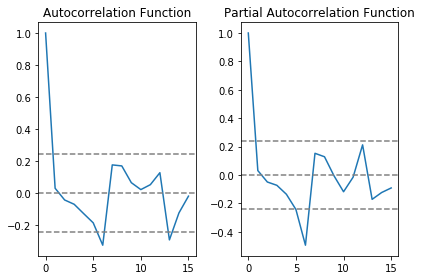

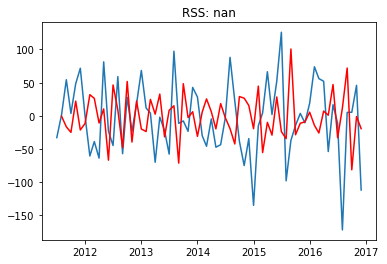

                             ARIMA Model Results                              
Dep. Variable:               D.FL_IMP   No. Observations:                   65
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -366.571
Method:                       css-mle   S.D. of innovations             67.955
Date:                Mon, 27 Nov 2017   AIC                            739.143
Time:                        22:04:11   BIC                            745.666
Sample:                    08-01-2011   HQIC                           741.717
                         - 12-01-2016                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.6277      5.826     -0.108      0.915     -12.046      10.791
ar.L1.D.FL_IMP    -0.4540      0.114     -3.993      0.000      -0.677      -0.231
                                    

In [81]:
    SeriePandas=SP.copy()
    #Elimina eventuali spazi vuoti
    SeriePandas = SeriePandas.dropna()
    #Calcola media mobile e deviazione standard su 12 periodi
    rolmean = SeriePandas.rolling(window=12,center=False).mean()
    rolstd  = SeriePandas.rolling(window=12,center=False).std()
    
    
    plt.plot(SP)
    plt.plot(rolmean)
    plt.title('Original series and Rolling Mean')
    plt.show()
    plt.plot(rolstd)
    plt.title('Rolling Standard Deviation')
    plt.show()
    
    
    dftest = adfuller(SeriePandas, autolag='AIC')
    print dftest
    print 'Results of Dickey-Fuller Test:'
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
    
    
    decomposition = seasonal_decompose(SeriePandas.dropna())

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    
    plt.subplot(411)
    plt.plot(SeriePandas, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    plt.show()
    
    dftest = adfuller(residual.dropna(), autolag='AIC')
    print dftest
    print 'Results of Dickey-Fuller Test:'
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
    
    lag_acf = acf(residual.dropna(), nlags=15)
    lag_pacf = pacf(residual.dropna(), nlags=15, method='ols')

    print 'lag ACF :  ',lag_acf
    print 'lag PACF : ',lag_pacf
    
    #Plot ACF: 
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(residual.dropna())),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(residual.dropna())),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
        
    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(residual.dropna())),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(residual.dropna())),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    plt.show()
    
    model = ARIMA(residual.dropna(),order=(1,1,0))
    results_AR = model.fit(disp=-1)  
    plt.plot(residual.dropna())
    plt.plot(results_AR.fittedvalues, color='red')
    plt.title('RSS: %.4f'% sum((results_AR.fittedvalues.dropna()-residual.dropna())**2))
    plt.show()
    
    print results_AR.summary()
    print results_AR.forecast(steps=4)
    #print results_AR.forecast()[1]
    #plt.plot(results_AR.forecast(12))
    #plt.show()

In [78]:
help(ARIMAResults)

Help on class ARIMAResults in module statsmodels.tsa.arima_model:

class ARIMAResults(ARMAResults)
 |  Method resolution order:
 |      ARIMAResults
 |      ARMAResults
 |      statsmodels.tsa.base.tsa_model.TimeSeriesModelResults
 |      statsmodels.base.model.LikelihoodModelResults
 |      statsmodels.base.model.Results
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  forecast(self, steps=1, exog=None, alpha=0.05)
 |      Out-of-sample forecasts
 |      
 |      Parameters
 |      ----------
 |      steps : int
 |          The number of out of sample forecasts from the end of the
 |          sample.
 |      exog : array
 |          If the model is an ARIMAX, you must provide out of sample
 |          values for the exogenous variables. This should not include
 |          the constant.
 |      alpha : float
 |          The confidence intervals for the forecasts are (1 - alpha) %
 |      
 |      Returns
 |      -------
 |      forecast : array
 |          Array of ou

In [4]:
class Application(tk.Frame):
    def __init__(self, master=None):
        tk.Frame.__init__(self, master)
        self.grid()
        self.createWidgets()

    def createWidgets(self):
        self.imglogo = PIL.Image.open('Logo.jpg')
        self.imgA = self.imglogo.resize(size=(600,150))
        self.imgB = PIL.ImageTk.PhotoImage(self.imgA)
        self.canvas1 = tk.Canvas(self,width=600,height=150)
        self.canvas1.create_image(300,75,image=self.imgB)
        self.canvas1.grid()
        
        self.label = tk.Label(text = 'Last consuntive '+Lastcons())
        self.label.grid()
        
        self.quitButton = tk.Button(self, text='Quit', background='darkred', command=self.quit)
        self.quitButton.grid()
        
    def quit(self):
        self.destroy()
        return 

app = Application()
app.master.title('New Customers Forecast Application - rel. 1.0 - (C) Gianni Zattoni')
app.mainloop()


AttributeError: 'module' object has no attribute 'ImageTk'

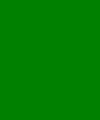

In [5]:
imA = PIL.Image.new(mode='RGB',size=(100,120),color='green')
imA

In [6]:
imglogo = PIL.Image.open('Logo.jpg')
imB = imglogo
#imB = PIL.ImageTk.PhotoImage(imglogo)
label = tk.Label(image=imB)
label.grid()

TclError: image "<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080 at 0x7F301B706710>" doesn't exist

In [7]:
# Frame principale
class Application(tk.Frame):
    def __init__(self, master=None):
        tk.Frame.__init__(self, master)
        self.grid()
        self.createWidgets()

    def createWidgets(self):
        
        self.imglogo = PIL.Image.open('Logo.jpg')
        self.imgA = self.imglogo.resize(size=(600,150))
        self.imgB = PIL.ImageTk.PhotoImage(self.imgA)
        self.canvas1 = tk.Canvas(self,width=600,height=150)
        self.canvas1.create_image(300,75,image=self.imgB)
        self.canvas1.grid()
        
        self.label = tk.Label(text = 'Last consuntive '+Lastcons())
        self.label.grid()
        
        self.quitButton = tk.Button(self, text='Quit', command=self.quit)
        self.quitButton.grid()
        
    def quit(self):
        self.destroy()
        return 

app = Application()
app.master.title('New Customers Forecast Application - rel. 1.0 - (C) Gianni Zattoni')
app.mainloop()


AttributeError: 'module' object has no attribute 'ImageTk'

In [3]:
print Lastcons()

2017/06


In [27]:
help('PIL.ImageTk')

Help on module PIL.ImageTk in PIL:

NAME
    PIL.ImageTk

FILE
    /home/kaidan/anaconda2/lib/python2.7/site-packages/PIL/ImageTk.py

DESCRIPTION
    # The Python Imaging Library.
    # $Id$
    #
    # a Tk display interface
    #
    # History:
    # 96-04-08 fl   Created
    # 96-09-06 fl   Added getimage method
    # 96-11-01 fl   Rewritten, removed image attribute and crop method
    # 97-05-09 fl   Use PyImagingPaste method instead of image type
    # 97-05-12 fl   Minor tweaks to match the IFUNC95 interface
    # 97-05-17 fl   Support the "pilbitmap" booster patch
    # 97-06-05 fl   Added file= and data= argument to image constructors
    # 98-03-09 fl   Added width and height methods to Image classes
    # 98-07-02 fl   Use default mode for "P" images without palette attribute
    # 98-07-02 fl   Explicitly destroy Tkinter image objects
    # 99-07-24 fl   Support multiple Tk interpreters (from Greg Couch)
    # 99-07-26 fl   Automatically hook into Tkinter (if possible)
    #

In [24]:
# Funzione che prepara un grafico e lo salva in una figura
def SimplePlot(SeriePandas=None,LabelofSerie=None):
    plt.plot(SeriePandas,label=LabelofSerie)
    plt.legend()
    plt.show()
    return plt.figure()

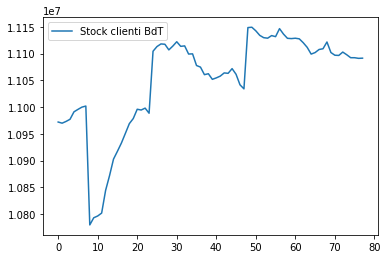

In [25]:
SimplePlot(df_totbdt['ST_BDT'],'Stock clienti BdT')

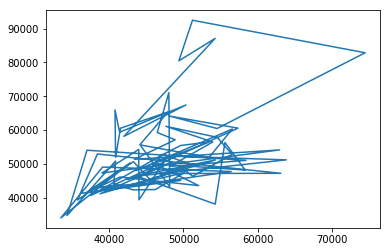

In [17]:
plt.plot(df_totbdt['CP_BDT'],df_totbdt['FL_BDT'])
plt.show()
#plt.gcf().canvas.draw()
fig = plt.figure()

In [19]:
fig
print fig

Figure(432x288)


In [9]:
import PIL

In [10]:
# create the canvas, size in pixels
canvas = tk.Canvas(width=500, height=200, bg='black')

# pack the canvas into a frame/form
canvas.grid() #expand=YES, fill=BOTH)

# load the .gif image file
logo = PIL.Image.open("Logo.jpg")
gif1 = PIL.ImageTk.PhotoImage(logo)

# put gif image on canvas
# pic's upper left corner (NW) on the canvas is at x=50 y=10
canvas.create_image(50, 10, image=gif1, anchor=N)

AttributeError: 'module' object has no attribute 'ImageTk'

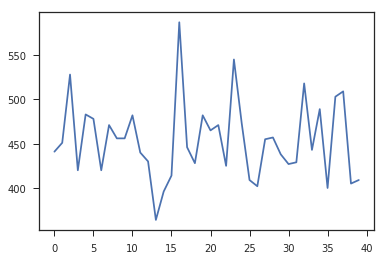

<class 'matplotlib.figure.Figure'>


IndexError: tuple index out of range

In [31]:

# prova di visualizzazione del grafico

#sb.set(style="ticks")
#pos = rs.randint(-1, 2, (20, 5)).cumsum(axis=1)
#pos -= pos[:, 0, np.newaxis]
#step = np.tile(range(5), 20)
#walk = np.repeat(range(20), 5)

# Initialize a grid of plots with an Axes for each walk
#grid = sb.FacetGrid(d_somma, col="walk", hue="walk", col_wrap=5, size=1.5)

# Draw a horizontal line to show the starting point
#grid.map(plt.axhline, y=0, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
#grid.map(plt.plot, "step", "position", marker="o", ms=4)

# Adjust the tick positions and labels
#grid.set(xticks=np.arange(5), yticks=[-3, 3],
#         xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

# Adjust the arrangement of the plots
#grid.fig.tight_layout(w_pad=1)



print type(fig)
graphic = tk.Canvas(app)
q = graphic.create_image(x=1, y=1, image=fig) #canvas.get_tk_widget().grid(row=1,column=24)
canvas.draw()


# create the canvas, size in pixels
#canvas = Canvas(width=300, height=200, bg='black')

# pack the canvas into a frame/form
#canvas.pack(expand=YES, fill=BOTH)

# load the .gif image file
#gif1 = PhotoImage(file='small_globe.gif')

# put gif image on canvas
# pic's upper left corner (NW) on the canvas is at x=50 y=10
#canvas.create_image(50, 10, image=gif1, anchor=N

In [ ]:
import 